# Neural Network Implementation from Scratch

In this notebook, I implement a neural network from scratch using Python and NumPy. The framework consists of several core classes that together handle the forward pass, backward pass, and training using stochastic gradient descent (SGD).

---

## 🔧 `Layer` Class

This class represents a fully connected layer in the neural network. It includes the following key components:

- **`setup(input_size)`**: Initializes the weights and biases for the layer based on the input size.
- **`forward(input)`**: Computes the output of the layer by applying the weighted sum and the chosen activation function.
- **`backward(output_gradient, learning_rate)`**: Computes the gradients of the loss with respect to the layer’s parameters and updates the weights and biases accordingly.

The backward function propagates the gradient from the current layer to the previous one using the chain rule. Three activation functions are supported:
- ReLU
- Sigmoid
- Tanh

For each activation function, both the function itself and its derivative are implemented.

---

## 📈 `SoftmaxLayer`

This class takes the final output of the last layer (a NumPy array) and applies the softmax transformation to convert raw scores into probability distributions.

---

## 🧮 `CrossEntropyLoss`

The `CrossEntropyLoss` class implements the categorical cross-entropy loss, commonly used for classification problems. It has:

- **`forward(predictions, targets)`**: Computes the loss.
- **`backward()`**: Calculates the gradient of the loss with respect to the output of the last layer.

---

## 🧠 `Network` Class

This class defines the overall structure and training process of the neural network. Its key functionalities include:

- **`add(layer)`**: Adds a new layer to the network.
- **`setup()`**: Prepares the network by initializing all layers with the appropriate input/output dimensions.
- **`forward(input, target)`**: Performs a complete forward pass through all layers and computes the loss.
- **`backward(learning_rate)`**: Propagates the gradient backward and updates all parameters.

### 🌀 `SGD` Training

The network includes a method called `SGD` (Stochastic Gradient Descent) for training. It:
- Accepts a batch size and number of epochs.
- Randomly shuffles the data at each epoch.
- Trains the network on small batches for more efficient and generalizable updates.

---

This modular design allows for flexibility in defining different network architectures, activation functions, and training settings.


In [19]:
class Layer():
    def __init__(self, output_size, activation_function):
        self.input_size = None
        self.output_size = output_size
        self.input = None
        self.z = None  # pre-activation
        self.a = None  # post-activation (activated output)
        self.weights = None
        self.bias = None

        if activation_function == "relu":
            self.activation_function = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function")

    def setup(self, input_size):
        self.input_size = input_size
        self.weights = np.random.randn(self.input_size, self.output_size) * np.sqrt(2 / self.input_size)
        self.bias = np.zeros((1, self.output_size))

    def forward(self, input):
        self.input = input
        self.z = np.dot(self.input, self.weights) + self.bias
        self.a = self.activation_function(self.z)
        return self.a

    def backward(self, output_gradient, learning_rate):
        dz = output_gradient * self.activation_derivative(self.z)
        dw = np.dot(self.input.T, dz)
        db = np.sum(dz, axis=0, keepdims=True)

        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

        return np.dot(dz, self.weights.T)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

class softmax_layer():
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        exp_input = np.exp(input - np.max(input, axis=1, keepdims=True))  # for stability
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        return self.output
class Cross_Entropy_layer():
    def __init__(self):
        self.target = None
        self.input = None
        self.loss = None

    def forward(self, input, target):
        self.input = np.clip(input, 1e-15, 1 - 1e-15)  # Avoid log(0)
        self.target = target
        self.loss = -np.sum(self.target * np.log(self.input)) / self.input.shape[0]
        return self.loss

    def backward(self):
        return (self.input - self.target) / self.input.shape[0]
class Network():

  def __init__(self , input_size ):
    self.layers = []
    self.in_dim =  input_size
    self.out_dim = None
    self.soft_max_layer = None
    self.cross_entropy = None
    self.input = None
    self.target = None
    self.number_of_Learnabale_param = 0

  def add(self, layer):
    self.layers.append(layer)

  def setup(self ):

    self.out_dim = self.layers[-1].output_size
    self.layers[0].setup(self.in_dim)
    input = self.in_dim
    for i in range(1, len(self.layers)):
      self.layers[i].setup(self.layers[i-1].output_size)
      self.number_of_Learnabale_param += input * self.layers[i].output_size + self.layers[i].output_size
      input = self.layers[i].output_size
    self.soft_max_layer = softmax_layer()
    self.cross_entropy = Cross_Entropy_layer()

  def number_of_Learnabale_param(self):

    return self.number_of_Learnabale_param


  def forward(self, input, target):
    self.input = input
    self.target = target
    current_output = self.layers[0].forward(self.input)
    for i in range(1, len(self.layers)):
        current_output = self.layers[i].forward(current_output)

    current_output = self.soft_max_layer.forward(current_output)
    self.cross_entropy.forward(current_output, self.target)
    return current_output , self.cross_entropy.loss


  def backward(self, learning_rate):
    output_gradient = self.cross_entropy.backward()
    for i in range(len(self.layers) - 1, -1, -1):
        output_gradient = self.layers[i].backward(output_gradient, learning_rate)


  def SGD(self, X, y, epochs=10, learning_rate=0.01, batch_size=1):
    num_samples = X.shape[0]

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_batch = X[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]

            _, loss = self.forward(X_batch, y_batch)
            self.backward(learning_rate)

        print(f"Loss after epoch {epoch + 1}: {loss:.4f}")


  def Test(self , X_test , y_test):
      correct = 0
      for i in range(len(X_test)):
        output , output1 = self.forward(X_test[i] , y_test)
        if np.argmax(output) == np.argmax(y_test[i]):
          correct += 1
      print("Accuracy: ", correct / len(X_test))
      return correct / len(X_test)


In [4]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [23]:
data = pd.read_csv('/content/breast-cancer-diagnostic.shuf.lrn.csv')


y_train =  pd.DataFrame( data['class'])
X_train =  pd.DataFrame( data.drop(['class' , 'ID'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)


# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = OneHotEncoder(sparse_output=False, dtype=int)
# Fit and transform
y_train = encoder.fit_transform(y_train)


## Architecture of the Neural Network

![Network Architecture](/content/network.png)
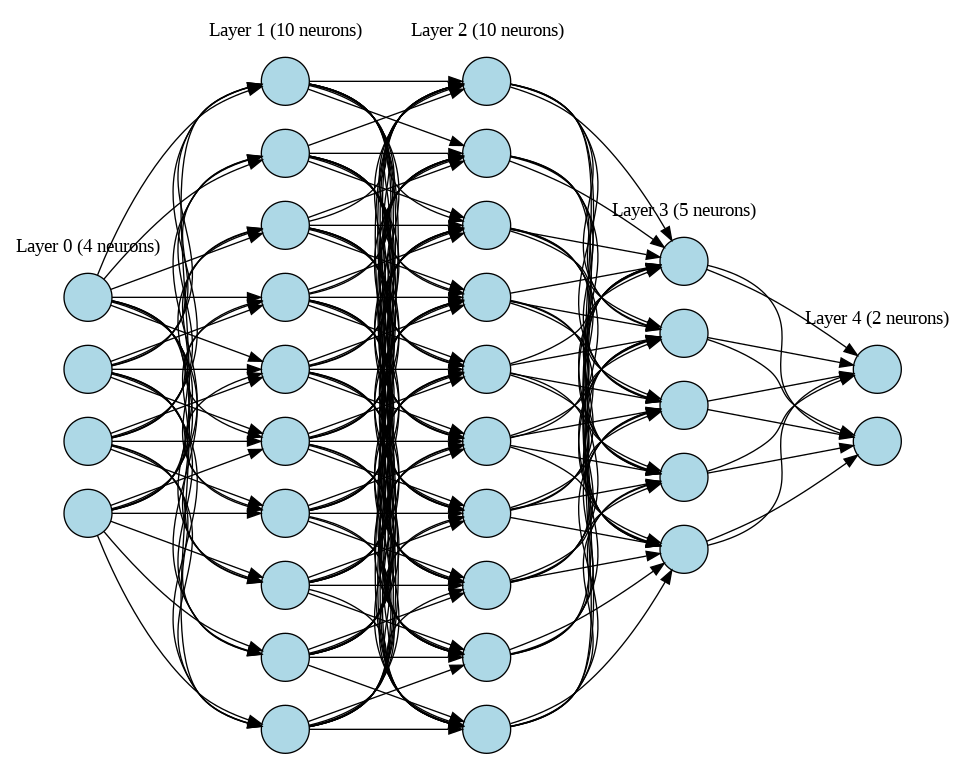

![]("content/network.png)

In [24]:
# Convert y_train to a numpy array before training


net = Network(input_size=30)
net.add(Layer(10, "relu"))
net.add(Layer(10, "relu"))
net.add(Layer(5, "relu"))
net.add(Layer(2, "sigmoid"))
net.setup()

print(net.number_of_Learnabale_param)
# Use the numpy array version of y_train for training
net.SGD(X_train, y_train, epochs=50, learning_rate=0.01, batch_size=1)

377
Epoch 1/50
Loss after epoch 1: 0.5562
Epoch 2/50
Loss after epoch 2: 0.3742
Epoch 3/50
Loss after epoch 3: 0.3153
Epoch 4/50
Loss after epoch 4: 0.3142
Epoch 5/50
Loss after epoch 5: 0.3138
Epoch 6/50
Loss after epoch 6: 0.3179
Epoch 7/50
Loss after epoch 7: 0.3340
Epoch 8/50
Loss after epoch 8: 0.3441
Epoch 9/50
Loss after epoch 9: 0.3136
Epoch 10/50
Loss after epoch 10: 0.3224
Epoch 11/50
Loss after epoch 11: 0.3161
Epoch 12/50
Loss after epoch 12: 0.3143
Epoch 13/50
Loss after epoch 13: 0.3133
Epoch 14/50
Loss after epoch 14: 0.3143
Epoch 15/50
Loss after epoch 15: 0.3135
Epoch 16/50
Loss after epoch 16: 0.3134
Epoch 17/50
Loss after epoch 17: 0.3136
Epoch 18/50
Loss after epoch 18: 0.3133
Epoch 19/50
Loss after epoch 19: 0.3136
Epoch 20/50
Loss after epoch 20: 0.3133
Epoch 21/50
Loss after epoch 21: 0.3133
Epoch 22/50
Loss after epoch 22: 0.3133
Epoch 23/50
Loss after epoch 23: 0.3133
Epoch 24/50
Loss after epoch 24: 0.3575
Epoch 25/50
Loss after epoch 25: 0.3133
Epoch 26/50
Lo

In [25]:
y_test = encoder.transform(y_test)
net.Test(X_test, y_test)

Accuracy:  0.9655172413793104


0.9655172413793104

### Appendix

The function below used to show the GUI of the arcitecture of the neural network.

In [26]:
from graphviz import Digraph

def visualize_network(layer_sizes):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to Right layout

    # Create nodes for each layer
    for l, size in enumerate(layer_sizes):
        with dot.subgraph(name=f'cluster_{l}') as c:
            c.attr(color='white')
            for n in range(size):
                c.node(f'L{l}_N{n}', shape='circle', label='', style='filled', fillcolor='lightblue')
            c.attr(label=f'Layer {l} ({size} neurons)')

    # Connect nodes
    for l in range(len(layer_sizes) - 1):
        for n1 in range(layer_sizes[l]):
            for n2 in range(layer_sizes[l+1]):
                dot.edge(f'L{l}_N{n1}', f'L{l+1}_N{n2}')

    return dot


In [28]:
layer_sizes = [4,10, 10,5, 2]  # [input, hidden1, hidden2, output]
visualize_network(layer_sizes).render('network', view=True)


'network.png'